In [4]:
!curl -LsSf https://astral.sh/uv/install.sh | sh

downloading uv 0.6.8 x86_64-unknown-linux-gnu
no checksums to verify
installing to /root/.local/bin
  uv
  uvx
everything's installed!


In [ ]:
!uv pip install --system transformers==4.49.0
!uv pip install --system datasets==3.3.2
!uv pip install --system accelerate==0.26.0
!uv pip install --system evaluate==0.4.3

In [37]:
import os
import glob
import pandas as pd
import torch
import matplotlib.pyplot as plt

from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

In [8]:
class Config:
    data_dir: str = "/kaggle/input/feedback-prize-2021/train"
    model_name: str = "BAAI/bge-small-en-v1.5"

In [15]:
def load_texts_from_dir(dir: str):
    files = glob.glob(os.path.join(dir, "*.txt"))
    texts = []
    
    for file in files:
        with open(file, "r", encoding="utf-8") as f:
            text = f.read().strip()
            texts.append(text)
    
    return texts

def prepare_dataset(dir: str):
    texts = load_texts_from_dir(dir)
    lengths = [len(text) for text in texts]
    
    return pd.DataFrame({"text": texts, "length": lengths})

def stratified_split(df: pd.DataFrame, test_size: int = 0.2, random_state: int = 42):
    df["length_bin"] = pd.qcut(df["length"], q=5, labels=False)  
    train_df, valid_df = train_test_split(df, test_size=0.2, stratify=df["length_bin"], random_state=42)
    
    train_df.drop(columns=["length_bin"], inplace=True)
    valid_df.drop(columns=["length_bin"], inplace=True)

    train_df["label"] = 0  
    valid_df["label"] = 1  

    return train_df, valid_df

In [16]:
df = prepare_dataset(Config.data_dir)
train_df, valid_df = stratified_split(df)

train_df.to_csv("train.csv", index=False)
valid_df.to_csv("valid.csv", index=False)

print(f"Train size: {len(train_df)}, Validation size: {len(valid_df)}")

Train size: 12475, Validation size: 3119


In [28]:
adv_df = pd.concat([train_df, valid_df]).reset_index(drop=True)

In [29]:
train_data, val_data = train_test_split( adv_df,
    test_size=0.2,
    stratify=adv_df['label'],  
    random_state=42
)

In [30]:
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length")

In [13]:
tokenizer = AutoTokenizer.from_pretrained(Config.model_name)

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [32]:
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

train_dataset = train_dataset.rename_column("label", "labels")
val_dataset = val_dataset.rename_column("label", "labels")
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/12475 [00:00<?, ? examples/s]

Map:   0%|          | 0/3119 [00:00<?, ? examples/s]

In [20]:
model = AutoModelForSequenceClassification.from_pretrained(Config.model_name, num_labels=2)

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    report_to=[]
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [34]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.405100,0.506248
2,0.483500,0.500625
3,0.350900,0.501282


TrainOutput(global_step=4680, training_loss=0.5086813244045291, metrics={'train_runtime': 949.6251, 'train_samples_per_second': 39.41, 'train_steps_per_second': 4.928, 'total_flos': 2465286924441600.0, 'train_loss': 0.5086813244045291, 'epoch': 3.0})

In [41]:
predictions = trainer.predict(val_dataset).predictions
probs = torch.nn.functional.softmax(torch.tensor(predictions), dim=-1)[:, 1].numpy()

y_true = val_dataset["labels"]
auc_score = roc_auc_score(y_true, probs)

print(f"Adversarial Validation AUC: {auc_score:.4f}")

Adversarial Validation AUC: 0.5101


In [42]:
fpr, tpr, _ = roc_curve(y_true, probs)

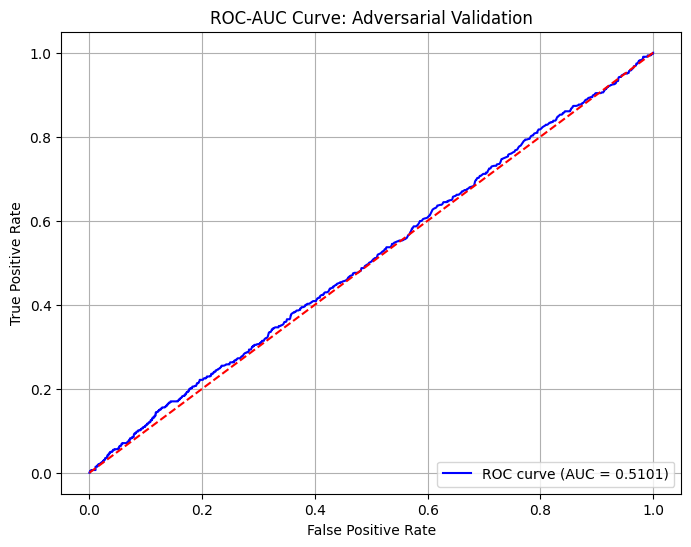

In [43]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_score:.4f})", color="blue")
plt.plot([0, 1], [0, 1], "r--")  
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve: Adversarial Validation")
plt.legend(loc="lower right")
plt.grid()
plt.show()